In [1]:
pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 3.8 MB/s eta 0:00:00


In [2]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
main_data=pd.read_csv("/content/drive/MyDrive/dataset/train.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


,label
0,29720
1,2242


0s : 1s  ::   13.26 : 1


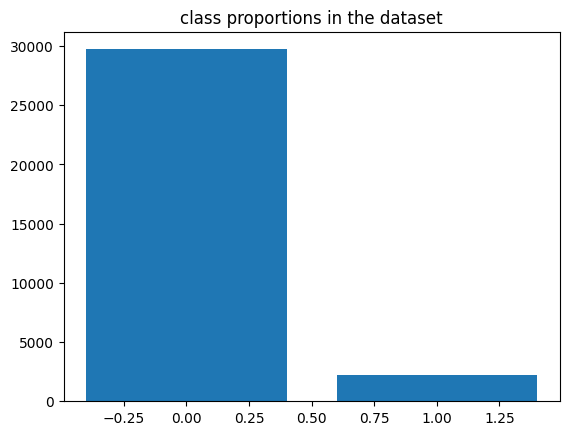

In [4]:
#Check class distribution in dependent variable 
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

#### we see that we have an unbalanced data mojority class to minority class ratio of 13 : 1

,label
0,29720
1,6726


0s : 1s  ::   4.42 : 1


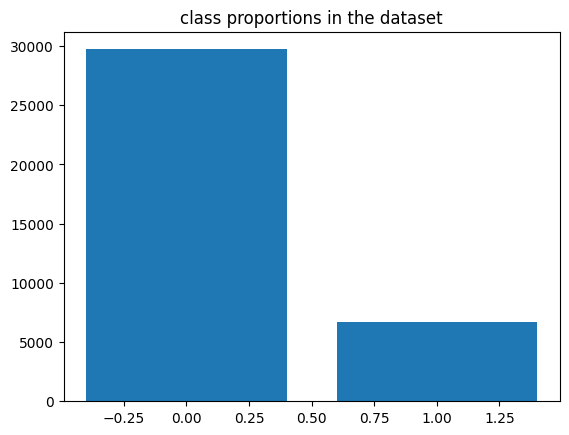

In [5]:
#Balancing the dataset using Oversampling
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1,data1], axis=0)
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [6]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)


def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [7]:
#preprocess train dataset
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split())) 

train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [8]:
#classes proportion in dependent variable in train and test dataset
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
0    23757
1     5399
Name: label, dtype: int64
29156
===========Test Data =========
0    5963
1    1327
Name: label, dtype: int64
7290


In [9]:
#train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:23324
Class distributionCounter({0: 19005, 1: 4319})
Valid data len:5832
Class distributionCounter({0: 4752, 1: 1080})


In [10]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [11]:
#convert sentences to sequences of numbers
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )

#padding 
maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())


print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

#tensorflow dataset preparation
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:23324
Class distributionCounter({0: 19005, 1: 4319})
Validation data len:5832
Class distributionCounter({0: 4752, 1: 1080})
Test data len:7290
Class distributionCounter({0: 5963, 1: 1327})


In [12]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[   12   587  8043  8043  1571 12532  2157    78   745 12533     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[    2   220     1 19311   911   195    65 15683  2864  1767   653     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Test dataset ====
tf.Tensor(
[  191   575 11471  1393   837   575 11471  1393   837     1    16   290
 16288     0     0     0     0     0     0     0     0     0     0     0
    

In [13]:
#model preparation
max_features =50000
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            800016    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 16)            2112      
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [14]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
23/23 [==============================] - 14s 407ms/step - loss: 2.9487 - binary_accuracy: 0.8098 - val_loss: 1.5552 - val_binary_accuracy: 0.8148
Epoch 2/10
23/23 [==============================] - 7s 304ms/step - loss: 1.1064 - binary_accuracy: 0.8148 - val_loss: 0.7818 - val_binary_accuracy: 0.8148
Epoch 3/10
23/23 [==============================] - 7s 317ms/step - loss: 0.7045 - binary_accuracy: 0.8148 - val_loss: 0.6024 - val_binary_accuracy: 0.8148
Epoch 4/10
23/23 [==============================] - 9s 384ms/step - loss: 0.5692 - binary_accuracy: 0.8148 - val_loss: 0.4895 - val_binary_accuracy: 0.8148
Epoch 5/10
23/23 [==============================] - 7s 283ms/step - loss: 0.4737 - binary_accuracy: 0.8620 - val_loss: 0.4187 - val_binary_accuracy: 0.9338
Epoch 6/10
23/23 [==============================] - 9s 379ms/step - loss: 0.4006 - binary_accuracy: 0.8925 - val_loss: 0.3422 - val_binary_accuracy: 0.9458
Epoch 7/10
23/23 [==============================] - 8s 330ms/st

In [15]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

183/183 [==============================] - 2s 9ms/step
[[4.5787822e-02]
 [9.7867692e-01]
 [1.3770991e-04]
 [8.5715568e-05]
 [4.9292488e-04]
 [1.1989861e-05]
 [9.5655960e-01]
 [7.2557920e-01]
 [7.4265299e-05]
 [7.2352846e-06]]


In [16]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)

228/228 [==============================] - 2s 10ms/step


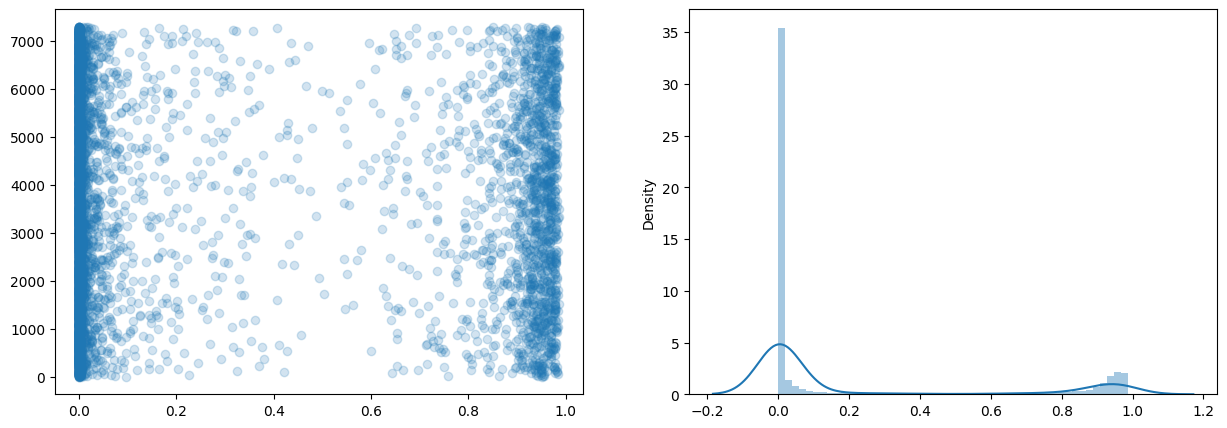

In [17]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

#### A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied

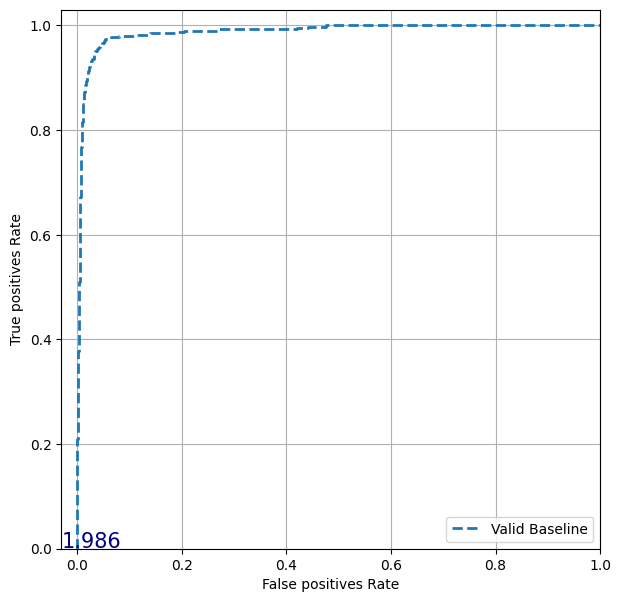

In [18]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [19]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5963
           1       0.95      0.86      0.90      1327

    accuracy                           0.97      7290
   macro avg       0.96      0.92      0.94      7290
weighted avg       0.97      0.97      0.97      7290



In [20]:
model.save("hate.h5")

## TESTING MODEL ON THE TEST DATASET PROVIDED

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
import snscrape.modules.twitter as sntwitter
scraper=sntwitter.TwitterSearchScraper("#feminist")
tweets=[]

for i,tweet in enumerate(scraper.get_items()):
  data=[
   
    tweet.id,
    tweet.content,
   
  ]
  tweets.append(data)
  if i > 500:
    break
tweet_df=pd.DataFrame(tweets,columns=['id','tweet'])
tweet_df.to_csv("python-tweets.csv",index=False)


In [ ]:
final_test = pd.read_csv("/content/python-tweets.csv", encoding="iso-8859-1")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))

array([[  73,   34,   20, ...,    0,    0,    0],
       [ 149,   72,  443, ...,    0,    0,    0],
       [   2,    2,    2, ...,    0,    0,    0],
       ...,
       [ 867,   29, 1934, ...,    0,    0,    0],
       [  15,  113,  244, ...,    0,    0,    0],
       [1267, 5022,  953, ...,    0,    0,    0]], dtype=int32)

array([[  12,  124,  930, ...,    0,    0,    0],
       [   1, 1346, 5909, ...,    0,    0,    0],
       [ 239, 2435,    1, ...,    0,    0,    0],
       ...,
       [   1, 2295, 5759, ...,    0,    0,    0],
       [4960,  666,  223, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#predict on actual test data
predictions = model.predict(f_test)

16/16 [==============================] - 0s 9ms/step


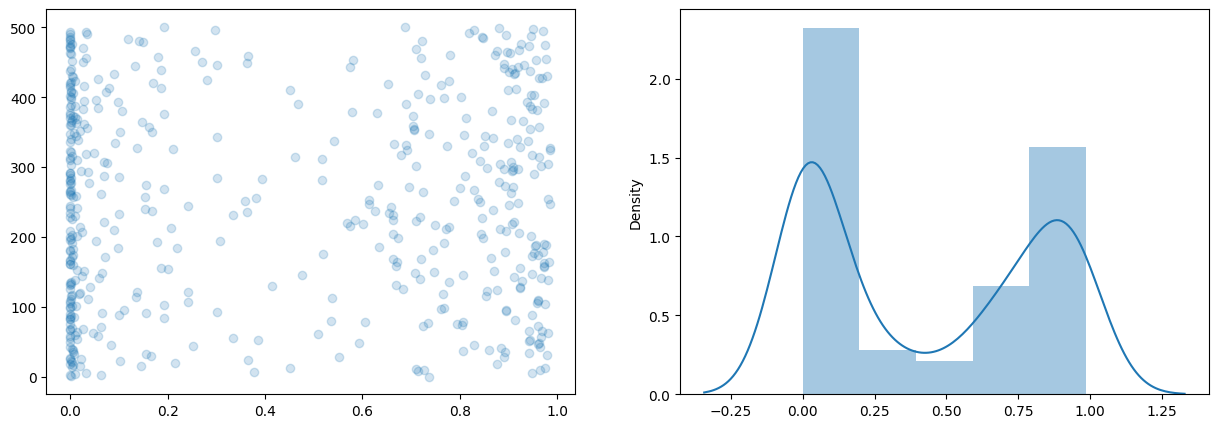

In [ ]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.2)
ax2=sns.distplot(predictions)

In [ ]:
#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]

,tweet,pred_sentiment
6,what type world were living where women trying trying women like srsly feminist trans womenmen women what about natural order your natural gender lgbt lgbtq feminist feminism httpstcovdtt4pkwi7,1.0
10,quiz which gender feminist term destructive httpstcotk2zxyptzz,1.0
12,feminist friendsanyone answer this feminism feminist humanrights httpstcoa5mrhbfmf2,1.0
19,what would mean have feminist httpstcokhn2pw1vhc robotics robot aiethics ethicalai openai bots opensource python tech technology data cobot humanoid humanoidrobot algorithms chatgpt chatbots sentient,1.0
28,sonal20112 reacted about comment about women leaving child front police after 15years feminist ðð¤ð¤ð¤ð¤,1.0
...,...,...
488,damnit wasnt patriarchy just plain white liberal feminist httpstcohctqiduf5j,1.0
489,every women western society should think this httpstcofq9wv0lauk feminism feminist femaleworship,1.0
495,dinosaur eats woman inherits earth magnet feminist feminism girls equality magnet httpstcoqacsdfackt,1.0
498,feminist feminism httpstcoaf8dwoljmw,1.0


In [ ]:
#actual tweets categorized as hate speech
final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

,id,tweet
6,1645737892390531072,In what type of world we're living in?\nWhere women trying to be men.\nAnd men trying be women.\nLike srsly?\nFeminist: we are men:\nTrans women(men): we are women\nWhat about the natural order your natural gender??\n#lgbt #lgbtq #feminist #Feminism https://t.co/vdTT4pKWi7
10,1645728148976279552,Now for a quiz.\nWhich sex (gender is a #feminist term) is the destructive one. https://t.co/tK2zXypTzZ
12,1645718637314207744,To my feminist friends..anyone can answer this? #Feminism #feminist #HumanRights https://t.co/A5MrHbfMF2
19,1645695279352430593,What would it mean to have #feminist AI?\n\nhttps://t.co/khN2pW1vHc\n\n#robotics #robot #AIEthics #EthicalAI #OpenAI #Bots #opensource #Python #tech #technology #Data #cobot #humanoid #humanoidrobot #AI #ML #DL #NLP #Algorithms #chatGPT #chatbots #sentient #RT
28,1645666129858416641,@sonal20112 You did not reacted about my comment about a women was leaving the child in front of police after 15years #feminist ðð¤ð¤ð¤ð¤
...,...,...
488,1644200718310469633,Damnit it wasnt the #Patriarchy \n\nIts was just Plain White Liberal #Feminist https://t.co/hctqiDuf5J
489,1644190685963141120,Every Women in Western Society should think this way:\nhttps://t.co/fq9wv0LAUK\n#Feminism #feminist #femaleworship
495,1644140797049073664,"""Dinosaur Eats Man, Woman Inherits the Earth"" Magnet #feminist, #feminism, #girls #can, #equality, #Magnet https://t.co/qACSDfAcKT"
498,1644124325207851010,#feminist #Feminism https://t.co/AF8DwoLJMW
